In [92]:
%matplotlib inline

import os, sys, json, warnings, time
warnings.filterwarnings("ignore")

from pathlib import Path

from sklearn.model_selection import StratifiedKFold, HalvingRandomSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import average_precision_score, roc_auc_score, brier_score_loss, precision_recall_curve
from sklearn.calibration import calibration_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_halving_search_cv

import category_encoders as ce

import tensorflow as tf
from keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping

from scikeras.wrappers import KerasClassifier

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

f"Tensor version: {tf.__version__}"

'Tensor version: 2.20.0'

Pfade definieren

In [88]:
# ---------- Paths ----------
if "__file__" in globals():
    ROOT = Path(__file__).resolve().parents[1]
else:
    ROOT = Path.cwd() if Path.cwd().name not in ("notebooks","tools","tests") else Path.cwd().parent

REPORTS_IN  = Path(os.getenv("REPORTS_IN")  or (ROOT / "reports"))         # shared inputs (split, features)
REPORTS_OUT = Path(os.getenv("REPORTS_OUT") or (ROOT / "reports_Charly/NN_target"))  
REPORTS_OUT.mkdir(parents=True, exist_ok=True)

# import loading method
sys.path.insert(0, str(ROOT))
from src.data_loader import load_and_save_data

Speed-Profile erstellen für die Berechnung der Modelle

In [73]:
# ---------- Speed/Profile ----------
SPEED = os.getenv("SPEED", "MEDIUM").upper().strip()
def speed_cfg():
    cfg = dict(CV=5, N_EST=6000, EARLY_STOP=200, MODELS=["lgbm","xgb"], LR=0.03)
    if SPEED == "FAST":
        cfg.update(CV=3, N_EST=2000, EARLY_STOP=50, MODELS=["lgbm"], LR=0.05)
    elif SPEED == "MEDIUM":
        cfg.update(CV=5, N_EST=4000, EARLY_STOP=100)
    elif SPEED == "FULL":
        cfg.update(CV=5, N_EST=8000, EARLY_STOP=300)
    return cfg

CFG        = speed_cfg()
RND        = int(os.getenv("RND", "42"))
CV         = int(os.getenv("CV", str(CFG["CV"])))
N_EST      = int(os.getenv("N_EST", str(CFG["N_EST"])))
ESR        = int(os.getenv("EARLY_STOP", str(CFG["EARLY_STOP"])))
MODELS     = [m.strip() for m in os.getenv("MODELS", ",".join(CFG["MODELS"])).split(",") if m.strip()]
IMB        = os.getenv("IMB", "spw").lower() 
LR         = float(os.getenv("LR", str(CFG["LR"])))
MEMBER     = os.getenv("MEMBER", "Charlotte")

Load the Dataset

In [74]:
# Laden des Datensatzes und alle -1 durch nan ersetzen, da das ML nicht mit nans umgehen kann
data = load_and_save_data().replace(np.nan, -1)

# zur Kontrolle
total_nans = data.isna().sum().sum()
print("total nans: ",total_nans)


Lade Datensatz aus dem Cache.
total nans:  0


Strukturierung des Datensatzes von Lucas
Es gibt vier verschiedene Modelle, die wir miteinander vergleichen: 
- drop_calc+opt+extras,37
- drop_calc+extras,39 
- drop_calc_only,37
- all_features,57

Entscheidung: alle ps_calc_* droppen (drop_calc_only),missing_count und sum_all_bin hinzufügen (drop_calc+extras),  zusätzlich ps_ind_14 und ps_car_10_cat droppen (drop_calc+opt+extras) 


In [75]:
# ---------- Utils ----------
# Variablen nach Skalenniveau sortieren
def split_cols(cols):
    cat = [c for c in cols if str(c).endswith("_cat")]
    bin = [c for c in cols if str(c).endswith("_bin")]
    num  = [c for c in cols if c not in cat and c not in bin and c != "target"]
    return cat, bin, num

# Extra-variablen erstellen
def fe_extras(X, selected):
    X = X.copy()
    if "missing_count" in selected:
        X["missing_count"] = X.isna().sum(axis=1)
    if "sum_all_bin" in selected:
        b = [c for c in X.columns if str(c).endswith("_bin")]
        X["sum_all_bin"] = X[b].sum(axis=1) if b else 0
    return X

# Datensatz mit ausgewählten Spalten erstellen
def load_selected_feature_list():
    f = REPORTS_IN / "features_selected.csv"
    if not f.exists():
        raise FileNotFoundError(f"Missing {f}. Run feature-gate first.")
    s = pd.read_csv(f)
    if "raw_feature" not in s.columns:
        raise ValueError("features_selected.csv must have column 'raw_feature'.")
    return s["raw_feature"].astype(str).tolist()

var_selected = load_selected_feature_list() # 35 Feature anstatt 57

# erstes Modell mit ausgewhälten Features
X = data[var_selected[:-2]]  # alles von Anfang bis zweitletzte Spalte
y = data["target"]

var_cat, var_bin, var_num = split_cols(X.columns)

X.shape, y.shape


((595212, 35), (595212,))

In [76]:
# zur Kontrolle
print(var_cat) # 13 Variablen
print(var_num) # 11 Variablen
print(var_bin) # 11 Variablen

['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_11_cat']
['ps_ind_01', 'ps_ind_03', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15']
['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin']


Train-Test Split

In [78]:
## Split von split_indices übernommen: 
split_p = REPORTS_IN / "split_indices.json"
split = json.loads(split_p.read_text())

# Datensatz aufsplitten nach der json-Datei
X_train = X.loc[split["train"]]
y_train = y.loc[split["train"]]
X_test = X.loc[split["test"]]
y_test = y.loc[split["test"]]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((200000, 35), (200000,), (50000, 35), (50000,))

### Pre-Processing

Aus der EDA kennen wir die einzelne Variablen. 
- es müssen fehlende Werte ersetzt werden
- Kategoriale Variablen mit weniger als 10 Variablen onehotencoden mit fehlenden Werten als eigene Kategorie und größere Varialben mit Target Encoder verwerten
- Standardisierung der numerischen Variablen

Alle Variablen mit 3 Levels sind eigentlich auch binär, nur die fehlenden Werte müssen imputiert werden 
Alle Variablen mit mehr als 3 Leves sind ordinal kodiert und werden nicht onehotencoded.

In [100]:
# Sortieren der kategorialen  Variablen nach vielen und wenigen Kategorien
small_cat = [col for col in var_cat if X[col].nunique() < 10]
large_cat = [col for col in var_cat if X[col].nunique() >= 10]
small_cat,large_cat

(['ps_ind_02_cat',
  'ps_ind_04_cat',
  'ps_ind_05_cat',
  'ps_car_02_cat',
  'ps_car_03_cat',
  'ps_car_05_cat',
  'ps_car_07_cat',
  'ps_car_08_cat',
  'ps_car_09_cat'],
 ['ps_car_01_cat', 'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_11_cat'])

In [103]:
for var in large_cat: 
    print(var, X[var].unique())

ps_car_01_cat [10. 11.  7.  6.  9.  5.  4.  8.  3.  0.  2.  1. -1.]
ps_car_04_cat [0 1 8 9 2 6 3 7 4 5]
ps_car_06_cat [ 4 11 14 13  6 15  3  0  1 10 12  9 17  7  8  5  2 16]
ps_car_11_cat [ 12  19  60 104  82  99  30  68  20  36 101 103  41  59  43  64  29  95
  24   5  28  87  66  10  26  54  32  38  83  89  49  93   1  22  85  78
  31  34   7   8   3  46  27  25  61  16  69  40  76  39  88  42  75  91
  23   2  71  90  80  44  92  72  96  86  62  33  67  73  77  18  21  74
  37  48  70  13  15 102  53  65 100  51  79  52  63  94   6  57  35  98
  56  97  55  84  50   4  58   9  17  11  45  14  81  47]


In [104]:
# Pipeline für numerische Features
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Pipeline für kleine kategoriale Features
cat_small_pipeline = Pipeline([
    # kein Imputer, da -1 jetzt als eigene Kategorie mit einbezogen wird
    ("onehot", OneHotEncoder(sparse_output=False, drop='first', handle_unknown="ignore"))
])

# Pipeline für große kategoriale Features
target_encoder = ce.TargetEncoder(cols=["ps_car_11_cat"], smoothing=0.3) # Kategorie mit höchster Kardinalität
cat_large_pipeline = Pipeline([
    # kein Imputer, da -1 jetzt als eigene Kategorie mit einbezogen wird
    ("encoder", target_encoder)
])

# Pipeline für binäre Features
bin_pipeline = Pipeline([
    # bei binären Variablen wird die häufigste Kategorie gewählt, damit sie binär bleiben und keine 3. Kategorie dazu kommt
    ("impute", SimpleImputer(strategy="most_frequent", missing_values=-1))
])

ps_preprocessor = ColumnTransformer([
    ("var_num", num_pipeline, var_num),
    ("small_cat", cat_small_pipeline, small_cat),
    ("large_cat", cat_large_pipeline, large_cat),
    ("var_bin", bin_pipeline, var_bin)
])

ps_preprocessor

,transformers,"[('var_num', ...), ('small_cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [105]:
# Transformieren der Daten
X_processed_train = ps_preprocessor.fit_transform(X_train, y_train)
X_processed_test = ps_preprocessor.transform(X_test)


print(X_processed_train.shape, X_processed_test.shape)


(200000, 53) (50000, 53)


Model Setup

In [120]:
# Model als Funktion definieren, um Kreuzvalidierung durchführen zu können
def create_model(X_processed_train):
    inputs = Input(shape=(X_processed_train,), name = "data_input")
    
    x = Dense(64, activation='relu')(inputs)
    x = Dense(32, activation='relu')(x)
    output = Dense(1,activation='sigmoid')(x)

    model = Model(inputs = inputs, outputs = output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 
    return model

In [122]:
y_train.shape

(200000,)

Model Training

In [123]:
# Modeldefinieren
model_base = create_model(X_processed_train.shape[1])

# Parameter definieren
epochs = 10
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Zeit messen
start = time.perf_counter()

# Modell trainieren
history_base = model_base.fit(
    X_processed_train, y_train,
    validation_data=(X_processed_test, y_test),
    epochs=epochs, 
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9634 - loss: 0.1563 - val_accuracy: 0.9634 - val_loss: 0.1531
Epoch 2/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9634 - loss: 0.1540 - val_accuracy: 0.9634 - val_loss: 0.1536
Epoch 3/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9634 - loss: 0.1535 - val_accuracy: 0.9634 - val_loss: 0.1525
Epoch 4/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9634 - loss: 0.1533 - val_accuracy: 0.9634 - val_loss: 0.1531
Epoch 5/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9634 - loss: 0.1529 - val_accuracy: 0.9634 - val_loss: 0.1549
Epoch 6/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9634 - loss: 0.1527 - val_accuracy: 0.9634 - val_loss: 0.1525


Grafiken für Trainingsverlauf
- Trainings- und Validierungs-Loss
- Accuracy

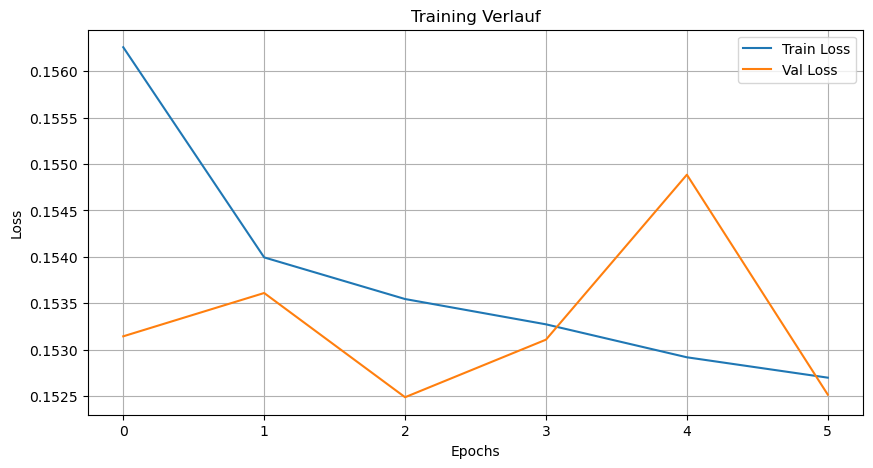

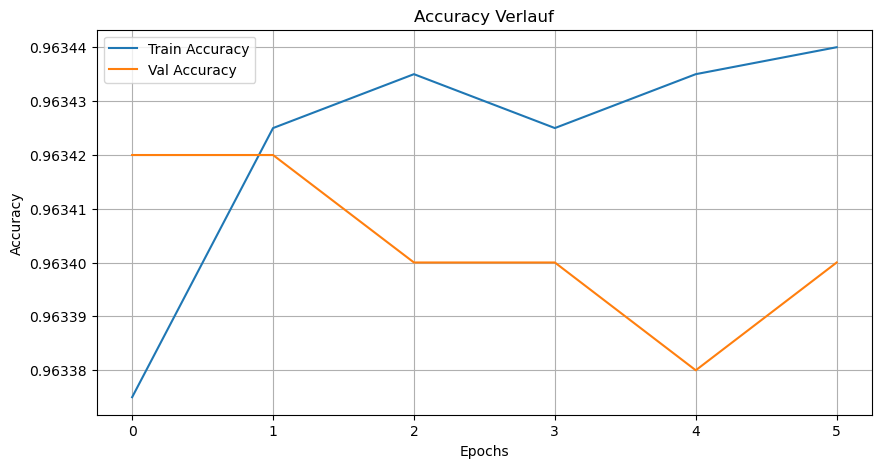

In [124]:
# Trainings- und Validierungs-Loss
plt.figure(figsize=(10,5))
plt.plot(history_base.history['loss'], label='Train Loss')
plt.plot(history_base.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Verlauf')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig(REPORTS_OUT/"plot_train_loss.png", dpi=150); plt.close()

# Accuracy
plt.figure(figsize=(10,5))
plt.plot(history_base.history['accuracy'], label='Train Accuracy')
plt.plot(history_base.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Verlauf')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig(REPORTS_OUT/"plot_accuracy.png", dpi=150); plt.close()


In [ ]:
#Validierungskurve: 
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(12, 5))

plot_validation_curve(
    estimator=clone(rf_pipeline),
    param_name="randomforestclassifier__max_features",
    param_values=np.arange(0.1, 1.1, 0.1),
    X=df_train,
    y=y_train,
    scoring="average_precision",
    plot_both=True,
    logx=False,
    ax=ax1,
)

plot_validation_curve(
    estimator=clone(rf_pipeline),
    param_name="randomforestclassifier__max_features",
    param_values=np.arange(0.1, 1.1, 0.1),
    X=df_train,
    y=y_train,
    scoring="roc_auc",
    plot_both=True,
    logx=False,
    ax=ax2,
)

Hyperparameter optimieren:
- Zu optimierende Parameter beim neuronalen Netz: 
learning rate, number of layers, number of "neurons" per layer, type of layers,
- Lernkurve ansehen, um Zusammenhang zwischen Performance und Anzahl an benötigten Daten zu sehen
- Optimierung mit Halving Search da es sehr sparsam ist

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

train_sizes = np.arange(0.05, 1.05, 0.05)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1)

ax1.set_title("Default parameters")
ax1.grid(True)
LearningCurveDisplay.from_estimator(
    estimator=clone(rf_pipeline),
    X=df_train,
    y=y_train,
    train_sizes=train_sizes,
    cv=cv,
    shuffle=True,
    score_type="both",
    line_kw={"marker": "o"},
    score_name="average_precision",
    ax=ax1,
    verbose=1,
)

min_samples_leaf = 4
ax2.set_title(f"{min_samples_leaf=}")
ax2.grid(True)
LearningCurveDisplay.from_estimator(
    estimator=clone(rf_pipeline).set_params(
        **{
            "randomforestclassifier__min_samples_leaf": min_samples_leaf,
        }
    ),
    X=df_train,
    y=y_train,
    train_sizes=train_sizes,
    cv=cv,
    shuffle=True,
    score_type="both",
    line_kw={"marker": "o"},
    score_name="average_precision",
    ax=ax2,
    verbose=1,
)

In [ ]:
rom sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

df_train.shape, y_train.shape

•	# Wrapper für Multi-Input NN
•	def create_model_wrap(**kwargs):
•	    # Parameter setzen
•	    embedding_dim = kwargs.ge('embedding_dim',8)
•	    neurons = kwargs.get('neurons',)
•	    dropout = kwargs.get('dropout', 0.2)
•	  
•	     # Inputs vorbereiten
•	    num_inputs = X_processed_train.shape[1]
•	    cat_inputs = [int(np.max(X_large_train[:, i])) + 1 for i in range(X_large_train.shape[1])]
•	    
•	    inputs_preprocessed = Input(shape=(num_inputs,), name="preprocessed_input")
•	    inputs_large = []
•	    embeddings = []
•	
•	    for i, n_cat in enumerate(cat_inputs):
•	        inp = Input(shape=(1,), dtype='int32', name=f"cat_input_{i}")
•	        emb = Flatten()(Embedding(input_dim=n_cat, output_dim=embedding_dim)(inp))
•	        inputs_large.append(inp)
•	        embeddings.append(emb)
•	
•	    x = Concatenate()( [inputs_preprocessed] + embeddings )
•	    x = Dense(neurons, activation='relu')(x)
•	    x = Dropout(dropout)(x)
•	    x = Dense(neurons//2, activation='relu')(x)
•	    output = Dense(1, activation='sigmoid')(x)
•	
•	    model = Model(inputs=[inputs_preprocessed]+inputs_large, outputs=output)
•	    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
•	    return model
•	
•	keras_clf = KerasClassifier(
•	    build_fn=create_model_wrap,
•	    epochs=5,       # max Epochen pro Runde
•	    batch_size=32,
•	    verbose=0
•	)
•	
•	# Parameterraum
•	param_dist = {
•	    'embedding_dim': [4, 8, 16],
•	    'neurons': [32, 64],
•	    'dropout': [0.1, 0.2],
•	    'batch_size': [32, 64]
•	}
•	
•	halving_search = HalvingRandomSearchCV(
•	    estimator=keras_clf,
•	    param_distributions=param_dist,
•	    factor=2,        # wie viele Ressourcen multipliziert werden pro Runde
•	    random_state=42,
•	    scoring='roc_auc',
•	    cv=3,
•	    min_resources= 4, # da base-model bei 4 Epochen gestoppt hat, sollen alle Kandidaten mindestens 4 Epochen durchlaufen
•	    n_jobs=1         # Parallelisierung optional
•	)
•	
•	# Flattened Input für scikit-learn (numerische + kategorische Spalten)
•	X_flat = np.hstack([X_processed_train] + [X_large_train[:, i:i+1] for i in range(X_large_train.shape[1])])
•	
•	halving_search.fit(X_flat, y_train.to_numpy())
•	
•	print("Beste Parameter:", halving_search.best_params_)
•	print("Beste AUC:", halving_search.best_score_)


In [66]:
Modelstruktur anpassen

# Model als Funktion definieren, um Kreuzvalidierung durchführen zu können
def create_model(input_processed, input_large_raw, embedding_dim =8):
    inputs_preprocessed = Input(shape=(input_processed,), name = "Preprocessed_input")
    inputs_large = []
    embeddings = []

    # Embeddings für jede Spalte der großen Variablen bestimmen
    for i, variable in enumerate(input_large_raw):
        inp = Input(shape=(1,), dtype = tf.int32, name =f"cat_input_{i}")
        emb = Flatten()(Embedding(
            input_dim = variable,
            output_dim=embedding_dim
        )(inp))
        inputs_large.append(inp)
        embeddings.append(emb)
    
    # Alles zuEmbeddings und vorbereitete Features zusammenführen
    x = Concatenate() ([inputs_preprocessed] + embeddings)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(1,activation='sigmoid')(x)

    model = Model(inputs = [inputs_preprocessed] + inputs_large, outputs = output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 
    return model
# Input-Daten in eine Liste packen
train_inputs = [X_processed_train] + [X_large_train[:, i:i+1] for i in range(X_large_train.shape[1])]
test_inputs  = [X_processed_test]  + [X_large_test[:, i:i+1]  for i in range(X_large_test.shape[1])]

# Modeldefinieren
model_base = create_model(
    X_processed_train.shape[1],
    [int(np.max(X_large_train[:, i])) + 1 for i in range(X_large_train.shape[1])] , 
    embedding_dim=8
    )

# Parameter definieren
epochs = 10
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Zeit messen
start = time.perf_counter()

# Modell trainieren
history_base = model_base.fit(
    train_inputs, y_train,
    validation_data=(test_inputs, y_test),
    epochs=epochs, 
    batch_size=32,
    callbacks=[early_stop]
)

SyntaxError: invalid syntax (2702292382.py, line 1)

Vergleichsmetriken berechnen
- Crossvalidation
- Holdout
- Time

Durchführung der Kreuzvalidierung

In [68]:
skf = StratifiedKFold(n_splits=CV, shuffle=True, random_state=RND)
#skf = StratifiedKFold(n_splits =5, shuffle = True, random_state =RND)

auc_scores = []
ap_scores = []

# Input-Dimensionen vorbereiten
input_processed = X_processed_train.shape[1]
input_large = [int(np.max(X_large_train[:, i])) + 1 for i in range(X_large_train.shape[1])]


for train_idx, val_idx in skf.split(X_processed_train, y_train):
    # der Trainingsdatensatz wird in Trainings- und Validierungsteildatensatz gesplittet:
    X_processed_tr, X_processed_val = X_processed_train[train_idx], X_processed_train[val_idx]
    X_large_tr, X_large_val =  X_large_train[train_idx], X_large_train[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Inputs für Keras vorbereiten
    train_inputs = [X_processed_tr] + [X_large_tr[:, i:i+1] for i in range(X_large_tr.shape[1])]
    val_inputs =  [X_processed_val] + [X_large_val[:, i:i+1] for i in range(X_large_val.shape[1])]

    # Neues Model pro Fold erstellen
    model_cv = create_model(input_processed, input_large, embedding_dim=8)

    # Early Stopping
    early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
    
    # Trainieren der Modelle
    model_cv.fit(
        train_inputs, y_tr,
        validation_data = (val_inputs, y_val),
        epochs = 50, 
        batch_size = 32, 
        callbacks = [early_stop],
        verbose = 0
    )

    # Vorhersagen (Wahrscheinlichkeiten)
    y_val_pred = model_cv.predict(val_inputs, verbose=0).ravel()

    # Metriken
    auc_scores.append(roc_auc_score(y_val, y_val_pred))
    ap_scores.append(average_precision_score(y_val, y_val_pred))

# Ergebnisse
cv_auc_mean = np.mean(auc_scores)
cv_ap_mean = np.mean(ap_scores)

#best_model = max(baselines.items(), key=lambda kv: kv[1]["pr_auc"])[0]

print("CV AUC mean:", cv_auc_mean)
print("CV AP mean:", cv_ap_mean)

CV AUC mean: 0.6248196917183055
CV AP mean: 0.06248254717951881


Genauigkeit mit dem Testdatensatz überprüfen

In [69]:
# Holdout mit bisher nicht genutzten Testdaten

model_holdout = create_model(input_processed, input_large, embedding_dim = 8)

early_stop = EarlyStopping(monitor = "val_loss", patience =3, restore_best_weights=True)

model_holdout.fit(
    [X_processed_train] + [X_large_train[:, i:i+1] for i in range(X_large_train.shape[1])],
    y_train,
    validation_split=0.1,   # kleiner Teil für val_loss Monitoring
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Vorhersagen auf Holdout_Testset
y_pred_proba = model_holdout.predict(test_inputs, verbose=0).ravel()

# Metriken berechnen
hold_auc = roc_auc_score(y_test, y_pred_proba)
hold_ap = average_precision_score(y_test, y_pred_proba)
hold_brier = brier_score_loss(y_test, y_pred_proba)

print("Holdout AUC:", hold_auc)
print("Holdout AP:", hold_ap)
print("Holdout Brier Score:", hold_brier)

Epoch 1/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9637 - loss: 0.1546 - val_accuracy: 0.9610 - val_loss: 0.1617
Epoch 2/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9637 - loss: 0.1528 - val_accuracy: 0.9610 - val_loss: 0.1614
Epoch 3/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9637 - loss: 0.1521 - val_accuracy: 0.9610 - val_loss: 0.1620
Epoch 4/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9637 - loss: 0.1514 - val_accuracy: 0.9610 - val_loss: 0.1644
Epoch 5/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9637 - loss: 0.1508 - val_accuracy: 0.9610 - val_loss: 0.1622
Holdout AUC: 0.6361479066074058
Holdout AP: 0.06667380821351925
Holdout Brier Score: 0.03487788919957408


Zeitmessung

In [ ]:
# Zeitmetriken berechnen
fit_time_s = time.perf_counter() - start

# Vorhersagezeit auf 1000 Samples selbst berechnen, da keine eigene Metrik vorhanden
X_large_sample = X_large_test[:1000]
sample_inputs = [X_processed_test[:1000]] + [X_large_sample[:, i:i+1] for i in range(X_large_sample.shape[1])]

X_sample = X_test[:1000] # fixes Sample von 1000
start_1000 = time.perf_counter()
_ = model_base.predict(X_sample, verbose=0)
elapsed = (time.perf_counter() - start_1000) * 1000  # in ms
predict_time_ms_per_1k = elapsed

print("Fit time (s):", fit_time_s)
print("Predict time (ms/1k):", predict_time_ms_per_1k)

Fit time (s): 220.04740999999922
Predict time (ms/1k): 555.3538999520242


In [22]:
# beste Epoche (Epoche mit bestem Wert äquivalent zu best_iteration)
best_iteration = early_stop.stopped_epoch - early_stop.patience

print("Best iteration:", best_iteration)

Best iteration: 4


Zusammenfassung der Berichte

In [ ]:
# save predictions
pd.DataFrame({"proba": y_pred_proba, "y_true": y_test.values}).to_csv(REPORTS_OUT/"holdout_preds.csv", index=False)

# save metrics
row = {
    "member": MEMBER,
    "model_name": None, #best_model.upper(),
    "encoder": "OneHotEncoder and Embeddings for large categories",
    "split_path": str(split_p),  # das macht hier noch nicht so richtig Sinn
    "feature_recipe": "selected_from_feature_gate",
    "seed": RND, "cv_folds": CV,
    "hold_auc": hold_auc, "hold_ap": hold_ap, "hold_brier": hold_brier,
    "cv_auc_mean": cv_auc_mean, "cv_ap_mean": cv_ap_mean,
    "early_stopping": True,
    "best_iteration": best_iteration,
    "n_trees": (epochs, "Epochs"),
    "fit_time_s": fit_time_s,
    "predict_time_ms_per_1k": predict_time_ms_per_1k,
    "params_json": None, #json.dumps(best_params),
}

out_csv = REPORTS_OUT/"team_model_summary.csv"
pd.DataFrame([row]).to_csv(out_csv, mode="a", index=False, header=not out_csv.exists())

Grafiken erstellen
- ohne Feature Importance

In [28]:
def save_pr_curve(y_test, proba, out_path):
    import matplotlib.pyplot as plt
    prec, rec, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)
    plt.figure(figsize=(7,5))
    plt.plot(rec, prec, label=f'AP={ap:.4f}')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall')
    plt.xlim([0,1]); plt.ylim([0,1]); plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout(); plt.savefig(out_path, dpi=150); plt.close()

def save_calibration(y_test, proba, out_path):
    import matplotlib.pyplot as plt
    prob_true, prob_pred = calibration_curve(y_test, proba, n_bins=20, strategy="quantile")
    plt.figure(figsize=(6,6))
    plt.plot([0,1],[0,1],'--',label='Perfect')
    plt.plot(prob_pred, prob_true, marker='o', label='Model')
    plt.xlabel('Predicted'); plt.ylabel('Observed'); plt.title('Calibration')
    plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout(); plt.savefig(out_path, dpi=150); plt.close()


save_pr_curve(y_test.values, y_pred_proba, REPORTS_OUT/"plot_pr.png")
save_calibration(y_test.values, y_pred_proba, REPORTS_OUT/"plot_calibration.png")

In [ ]:
# eventuell später noch nach Hyperparametern berechnen
pd.DataFrame([{
    "model": best_model, "params": json.dumps(best_params),
    "pr_auc": pr_auc, "roc_auc": hold_auc["roc_auc"], "brier": hold_brier["brier"]
    }]).to_csv(REPORTS_OUT/"holdout_metrics.csv", index=False)

best_model = max(baselines.items(), key=lambda kv: kv[1]["pr_auc"])[0]